In [1]:
import ee
import geemap
import os
import pylab as plt
from geemap import cartoee

In [2]:
#GEE Authentication
# Either use the credentials approach using a json file or Authenticate
# service_account = 'serviceaccount.com'
# credentials = ee.ServiceAccountCredentials(service_account, 'location/to/json/file.json')
# ee.Initialize(credentials)

In [ ]:
ee.Initialize()

In [ ]:
ee.Authenticate()

In [3]:
# Input single feature shapefile for Area of Interest
aoi = geemap.shp_to_ee(r"Input\SHapefile\location.shp")

In [4]:
# Function to clip image to AOI
def clipper(image):
    return image.clip(aoi)

In [5]:
# This will create a weekly animation for the year 2019
start_year = 2019
end_year = 2019

In [6]:
# Defining No of Weeks
startWeek = 0
endWeek = (((end_year+1)-(start_year))*52)-1
# Creating a list of week numbers
time_list = ee.List.sequence(startWeek, endWeek)

start_date = str(start_year) + "-01-01"
end_date = str(end_year) + "-12-31" 

In [7]:
# Create CO Collection between two dates, selecting the needful band and clipping all images to AOI
dataset = ee.ImageCollection('COPERNICUS/S5P/NRTI/L3_CO')\
                .filterDate(start_date, end_date)\
                .select('CO_column_number_density')\
                .map(clipper)

# Making Weekly Composites since actual data has pixel drops
# Movers Variable
seven = 7

def func_upr (day):
    #Mover
    a = ee.Number.expression('day*x',{
    'day' : day,
    'x' : seven
    })
    start2 = ee.Date(start_date).advance(a,'day')
    img = dataset.filterDate(start2,start2.advance(seven, 'day')) \
                  .reduce(ee.Reducer.mean()) \
                  .set('system:time_start',(start2.millis()))

    img2 = img.rename('CO')
    return img2


collection = ee.ImageCollection.fromImages(time_list.map(func_upr).flatten())


mean_img = collection.mean()

vizParams = {
    'min': 0,
    'max': 0.05,
    'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']
}

In [8]:
# Just wanted to see what the collection looks like, you can totally skip this one to save computation time
collection

In [9]:
x=((end_year+1)-(start_year))*52
labels = [str(n).zfill(2) + " Week No " for n in range(0, x)]

In [10]:
# This is the manually identified centroid
lon = 77.216721
lat = 28.644800

In [11]:
videoParams = {
  'region': aoi,
  'framesPerSecond': 7,
  'crs': 'EPSG:4326',
  'min': 0,
  'max': 0.05,
  'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']
}

In [12]:
# We need a reference image to see if the visual parameters are working fine
image = ee.Image(collection.mean())

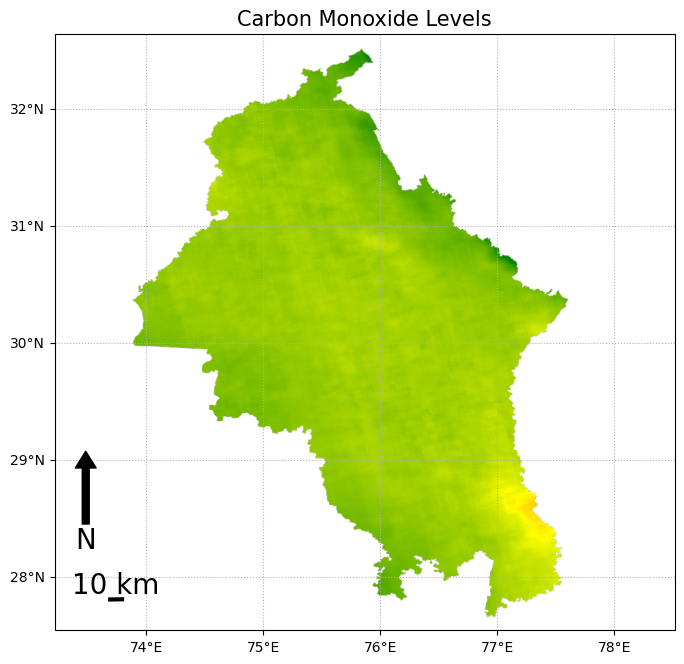

In [13]:
# This region extent is case specific and identified by trial and error
region = [lon + 1.3, lat - 1.1, lon - 4, lat + 4]

fig = plt.figure(figsize=(8, 8))

ax = cartoee.get_map(image, region=region, vis_params = vizParams)

# add gridlines to the map at a specified interval
cartoee.add_gridlines(ax, interval=[1.0, 1.0], linestyle=":")

# add north arrow
north_arrow_dict = {
    "text": "N",
    "xy": (0.05, 0.3),
    "arrow_length": 0.15,
    "text_color": "black",
    "arrow_color": "black",
    "fontsize": 20,
    "width": 5,
    "headwidth": 15,
    "ha": "center",
    "va": "center",
}
cartoee.add_north_arrow(ax, **north_arrow_dict)

# add scale bar
scale_bar_dict = {
    "length": 10,
    "xy": (0.1, 0.05),
    "linewidth": 3,
    "fontsize": 20,
    "color": "black",
    "unit": "km",
    "ha": "center",
    "va": "bottom",
}
cartoee.add_scale_bar_lite(ax, **scale_bar_dict)

ax.set_title(label='Carbon Monoxide Levels', fontsize=15)

plt.show()

In [14]:
# Make GIF and also save each frame in the "out_dir"
cartoee.get_image_collection_gif(
    ee_ic=collection,
    out_dir=os.path.expanduser("~/Downloads/timelapseCO_2019"),
    out_gif="animation.gif",
    vis_params=vizParams,
    region=region,
    fps=2,
    mp4=True,
    grid_interval=(1.0, 1.0),
    plot_title="Carbon Monoxide Levels",
    date_format='YYYY-MM-dd',
    fig_size=(10, 8),
    dpi_plot=100,
    file_format="png",
    north_arrow_dict=north_arrow_dict,
    scale_bar_dict=scale_bar_dict,
    verbose=True
)

GIF saved to C:\Users\nirwan\Downloads\timelapseCO_2019\animation.gif
MP4 saved to C:\Users\nirwan\Downloads\timelapseCO_2019\animation.mp4
